## Image Segmentation

Segmentation is just the classification of each pixel in the image to obtain information about the location and other attributes from the image.

Mainly, there are two types of segmentation: Semantic and Instance. 
- <strong>Semantic Segmentation</strong> is the basic definition meaning it classifies each pixel into a pre-defined class.
- <strong>Instance Segmentation</strong> differentiates the instances of the same classes. Meaning multiple findings of the same class are treated as seperate.

A classical example is:

![semantic_vs_instance](assets/semantic_vs_instance.png)

[Anurag Arnab, Shuai Zheng et. al 2018 “Conditional Random Fields Meet Deep Neural Networks for Semantic Segmentation”](https://ieeexplore.ieee.org/document/8254255)

A minesweeper-like example that Andrew Ng gives out in the Deep Learning Specialization courses.

![semantic_vs_instance](assets/minesweeper_segmentation.png)

## Building Blocks of Segmentation

<strong>Convolution Layers</strong> --> <strong>Pooling Layers</strong> --> <strong>Upsampling/Transpose Convolution</strong>

- Convolution layers are used to extract spatial features from the image as we have discussed in the previous lecture.
- Pooling Layers allow us to reduce spatial dimensions and condense important information which helps with the upsampling when a retained information is passed from the downsample layers.
- Upsampling/Transpose Convolution is the block where upsampling happens. The work of these layers can be summarized as to make upsampling learnable via weights and retained information over downsample layers.

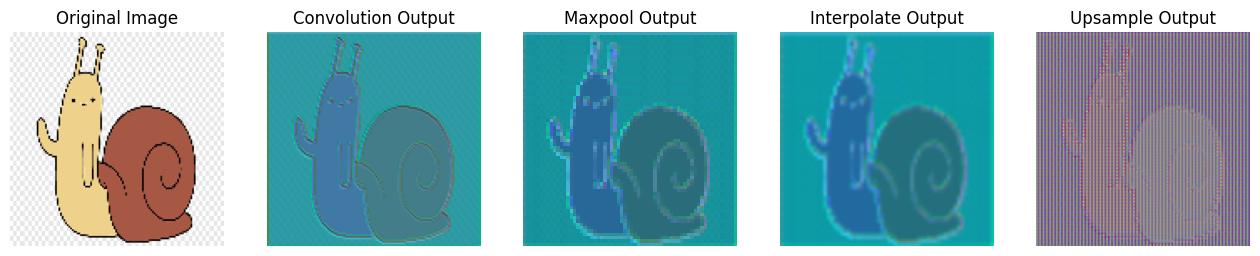

In [4]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(12)
np.random.seed(12)

SNAIL_SIZE = 128

# read and convert sample image
image_path = 'assets/snail.png'
image = cv2.imread(image_path)

image_resized = cv2.resize(image, (SNAIL_SIZE, SNAIL_SIZE))
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

image_tensor = torch.from_numpy(image_rgb).float() / 255.0
image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0)  # normalize and reshape to (1, 3, H, W)

# convolution
conv = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
conv_image = conv(image_tensor)

# max pooling
pool = torch.nn.MaxPool2d(2)
pooled_image = pool(conv_image)

# upsampling
interpolated_image = F.interpolate(pooled_image, scale_factor=2, mode='bilinear', align_corners=False)
conv_transpose = torch.nn.ConvTranspose2d(in_channels=3, out_channels=3, padding=0, dilation=1,
                                  kernel_size=2, stride=2, bias=False)
upsampled_image = conv_transpose(pooled_image)

def plot_snail(tensor, title):
    tensor = tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    plt.imshow(tensor)
    plt.title(title)
    plt.axis('off')

fig, axes = plt.subplots(1, 5, figsize=(16, 4))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

plt.subplot(1, 5, 2)
plot_snail(conv_image, "Convolution Output")

plt.subplot(1, 5, 3)
plot_snail(pooled_image, "Maxpool Output")

plt.subplot(1, 5, 4)
plot_snail(interpolated_image, "Interpolate Output")

plt.subplot(1, 5, 5)
plot_snail(upsampled_image, "Upsample Output")

plt.show()


## Popular Architectures

#### U-Net

** As we mostly dive into the deep learning aspects of segmentation, I'll pass on the techniques that include thresholding, clustering, histogram-based feature extractions to segment images. 
Main focus will be on the autoencoder-like architectures.

U-Net (<cite>[Ronneberger et al., 2015][1]</cite>) as can be seen in the image below, is an autoencoder architecture that utilizes skip connections and transpose convolutions to learn how to upsample an image. These design choices help the network to propagate information obtained on the early layers to better reconstructing a segmentation map.

Some key notes about U-Net
- High number of parameters
- Needs great computation power
- Needs large vram 
- Great with bigger data and balanced distributions
- Needs tuning or cannot perform well with smaller sets and highly unbalanced distributions
- Why do we even learn it, well... It is easier to learn from vanilla U-Net as other segmentation models are mostly built on top of this architecture.

![unet_architecture](assets/unet.png)

[1]: https://doi.org/10.48550/arXiv.1505.04597

#### What is this ? up-conv ¿

This layer has multiple aliases, some of them being: deconv, upconv, conv transpose

As you can see in the huuge image above, this layer is used when the upsampling happens in the network but how does it happen and where does the learning fit into this?

Operation is fairly simple:


![unet_architecture](assets/upconv.gif)

[link to gif](https://github.com/sicongzhao/Demystify-Transposed-Convolutional-Layers)

Normally with convolution, we would calculate the new shape as,
- $(H_{new} , W_{new}) = \lfloor\frac{[H, W] + 2P - F}{S}\rfloor + 1 $  
- [calculator for convolution shape if you are feeling down](https://madebyollin.github.io/convnet-calculator/)
- [another calculator with cool interactive visuals](https://zimonitrome.github.io/convolution-shape-calculator/)

where 
* $F$ is filter_size 
* $S$ is stride 
* $P$ is padding

With up-conv or transposed convolution, calculation becomes,

$(H_{new} , W_{new}) = S \cdot ([H, W] - 1) + F - 2P + P_{out} $

$(H_{new} , W_{new}) = S \cdot ([H, W] - 1) + D \cdot (F - 1) + 1 - 2P + P_{out} $ , same as above if $D = 1$

where
* $P_{out}$ is padding after the operation that may be applied
* $D$ is dilation but I have not seen an application for this in known papers

In [6]:
# to play with the shape
input_sample = torch.tensor([[
    np.ones((32, 32), dtype=np.float32)
    ]]) 

F, S = 2, 2  # if same -> H_in * value is new shape
P = 0
upconv = torch.nn.ConvTranspose2d(in_channels=1, out_channels=1, padding=P, dilation=1,
                                  kernel_size=F, stride=S, bias=False)  # trying to make it similar to the gif
upconv.weight.data = torch.ones(1, 1, F, F)

upconv(input_sample).shape

torch.Size([1, 1, 64, 64])

## Before going into practical case, how does labels work, how does it get stored?

It actually differs highly with the dataset and how the owner(s) wanted to construct it.
Mainly masks can be stored as:
- Just image files like .png, .jpeg (full image, costly to maintain due to high memory necessity)
- In yaml, json or xml files with different formats such as list of coordinates for the rectangles it contain to be reproduced. (polygons, low memory space)
- If you are working with a medical image or a hierarchical data that contains meta information -> hdf5, dicom, tiff are some of the used structures while working with high definition images

## But how would you use it in your life?

In [1]:
from utils.download_isic import download_set
from utils.unet import UNet
from utils.unet_dataloader import get_dataloaders
from torchvision import transforms
## use it carefully as the dataset is more than 12 GBs -> ~5.8 GB train, ~900 MB validation, ~5.4 GB test set

In [ ]:
# download_set("train")
# download_set("val")
# download_set("test")

In [2]:
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_loader, val_loader = get_dataloaders(batch_size=4,
                                           shuffle=True,
                                           transform=image_transforms,
                                           mask_transform=mask_transforms)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=1, out_channels=1).to(device)  # binary segmentation

In [ ]:
# visualize some samples

In [ ]:
# training logic

In [ ]:
# validation acc